# Autoencoders
# III. Conditional Variational Autoencoder

В предыдущих блокнотах мы обучали автоэнкодеры на датасете картинок и получали новые картинки, используя генерацию шума и декодер. 

Давайте предположим, что мы обучили автоэнкодер на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера. Но при этом хочется, чтобы была возможность сказать декодеру какую именно цифру (изображение какого класса) нам нужно получить на выходе.

Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Название "conditional" уже говорит само за себя.

В данном блокноте мы имплементируем свой Conditional Variational Autoencoder, обучим его. На основе этого CVAE мы сгенерируем изображения новых цифр заданных классов из одинаковых шумовых векторов. В конце посмотрим, как распределены вектора наших изображений в латентном пространстве CVAE отображённого на плоскость с помощью tSNE. Сравним полученное распределение точек с аналогичным для VAE, которое мы получили в [предыдущем блокноте](https://github.com/ivantipow/Autoencoders/blob/main/2_Variational_Autoencoder.ipynb).


## Содержание

- [Подготовка окружения](#environment)

- [Подготовка данных](#data)

- [Архитектура CVAE](#architecture_cvae)

- [Loss для CVAE](#loss)

- [Функция для обучения CVAE](#train_cvae_func)

- [Обучение CVAE](#cvae_train)

- [Sampling](#sampling_cvae)

- [Latent Representation](#latent_rep)

    


    
    

<a id='environment'></a>
## Подготовка окружения
Импортируем необходимые библиотеки

In [ ]:
import warnings
from IPython.display import clear_output
from tqdm import tqdm
from time import time
import seaborn as sns
import os
import pickle
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchsummary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import skimage.io
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patheffects as path_effects
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.2)


warnings.filterwarnings(action='ignore', category=DeprecationWarning)

[Reproducibility (Pytorch):](https://pytorch.org/docs/stable/notes/randomness.html)

In [ ]:
def set_seed(seed):
    """Установить зерно генераторов случайных чисел"""

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def seed_worker(worker_id):
    """Воспроизводимость DataLoader'a (см. ссылку выше)"""

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


set_seed(42)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
!nvidia-smi

Thu Jan  6 23:08:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    63W / 149W |    578MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Далее будем сохранять лучшие модели

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

DATA_DIR = '/content/gdrive/MyDrive/autoencoders/weights'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


<a id='data'></a>
## Подготовка данных

In [ ]:
batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True,
                               transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False,
                              transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                         shuffle=False)

In [ ]:
print(f'Размер обучающего датасета: {len(train_loader.dataset)}.')

print(f'Размер тестового датасета: {len(test_loader.dataset)}.')

Размер обучающего датасета: 60000.
Размер тестового датасета: 10000.


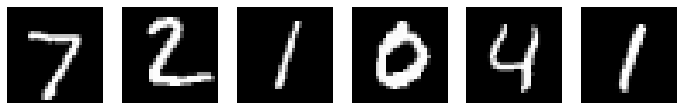

In [ ]:
numbers = next(iter(test_loader))

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(numbers[0][i].squeeze(0).numpy(), cmap='gray')

<a id='architecture_cvae'></a>
## Архитектура CVAE

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного VAE -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.

<img src="https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album" alt="CVAE"  height="400">


<img src="https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album" alt="CVAE2"  height="400">

Это всё также VAE, то есть latent у него все ещё состоит из μ и σ.

Таким образом, при генерации новой случайной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. На самом деле можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
dim_cvae = 8
num_classes = 10


class CVAE(nn.Module):
    """Conditional Variational Autoencoder"""

    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear((num_classes + 28*28), 64*8),
            nn.BatchNorm1d(64*8),
            nn.ReLU(True),

            nn.Linear(64*8, 64*2),
            nn.BatchNorm1d(64*2),
            nn.ReLU(True),

            nn.Linear(64*2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),

            nn.Linear(64, dim_cvae*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear((dim_cvae + num_classes), 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),

            nn.Linear(64, 64*2),
            nn.BatchNorm1d(64*2),
            nn.ReLU(True),

            nn.Linear(64*2, 64*8),
            nn.BatchNorm1d(64*8),
            nn.ReLU(True),

            nn.Linear(64*8, 28*28)
        )

        # "One-Hot" кодировщик
        self.lb = LabelBinarizer()

    def onehot(self, label, num_classes=num_classes):
        """Обучить кодировщик меток класса по схеме 1-of-K encoding.
        На вход получает метку класса. Возвращает соответствующий 
        единичный орт размерности num_classes.
            Пример:
            >>> onehot(3, num_classes=10)
            >>> tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
        """

        vector_labels = np.arange(num_classes)[:, None]
        lb_vectors = self.lb.fit_transform(vector_labels)  # Identity matrix
        lb_vector = torch.FloatTensor(lb_vectors[label.cpu()]).to(DEVICE)

        return lb_vector

    def encode(self, x, label):
        """Forward проход энкодера.
        В качестве возвращаемых переменных -- mu, logsigma и класс картинки
        """

        # Кодируем метку класса единичным ортом размерности num_classes
        lb_vector = self.onehot(label)

        # Во входном (первом) слое энкодера растягиваем картинку в вектор
        x = self.flatten(x)
        # Конкатенируем вектор-картинки с "вектором-метки"
        x = torch.cat((x, lb_vector), dim=-1)

        x = self.encoder(x)
        mu, logsigma = torch.split(x, dim_cvae, dim=1)

        return mu, logsigma, label

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # Засемплируем латентный вектор из нормального распределения с
            # параметрами mu и sigma
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
        else:
            # На инференсе возвращаем не случайный вектор из нормального
            # распределения, а центральный -- mu.
            # На инференсе выход автоэнкодера должен быть детерминирован.
            sample = mu

        return sample

    def decode(self, z, label, eps=1e-7):
        """Forward проход декодера.
        В качестве возвращаемой переменной -- reconstruction
        """

        # Кодируем метку класса единичным ортом размерности num_classes
        lb_vector = self.onehot(label)
        # Конкатенируем вектор-картинки с "вектором-метки"
        z = torch.cat((z, lb_vector), dim=1)

        z = self.decoder(z)
        reconstruction = torch.clamp(z.sigmoid(), min=eps, max=1-eps)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        return reconstruction

    def get_latent(self, x, label):
        # Кодируем метку класса единичным ортом размерности num_classes
        lb_vector = self.onehot(label)
        # Растягиваем картинку в вектор
        x = self.flatten(x)
        # Конкатенируем вектор-картинки с "вектором-метки"
        x = torch.cat((x, lb_vector), dim=-1)

        x = self.encoder(x)
        mu, logsigma = torch.split(x, dim_cvae, dim=1)

        # Латентный вектор из распределения (mu, sigma)
        z = self.gaussian_sampler(mu, logsigma)

        return z

    def forward(self, x, label):
        """Forward проход автоэнкодера.
        В качестве возвращаемых переменных -- mu, logsigma и reconstruction
        """

        mu, logsigma, label = self.encode(x, label)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, label).view(-1, 1, 28, 28)

        return mu, logsigma, reconstruction

In [ ]:
cvae = CVAE().to(DEVICE)

# Архитектура получившегося CVAE
print(cvae)

CVAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=

<a id='loss'></a>
## Loss для CVAE

Функцию потерь будем использовать такую же, как и для VAE -- сумму дивергенции Кульбака-Лейблера и кросс-энтропии (см. [предыдущий блокнот](https://github.com/ivantipow/Autoencoders/blob/main/2_Variational_Autoencoder.ipynb)).

In [ ]:
def KL_divergence(mu, logsigma):
    """Дивергенция Кульбака — Лейблера.
    Часть функции потерь, которая отвечает за "близость" латентных 
    представлений разных цифр
    """

    loss = torch.sum(mu.pow(2) + logsigma.exp() -
                     1 - logsigma) / (2*mu.shape[0])

    return loss


def log_likelihood(x, reconstruction):
    """ Логарифм правдоподобия.
    Часть функции потерь, которая отвечает за качество реконструкции 
    (как mse в обычном autoencoder, см. первый блокнот)
    """

    batch_size = x.shape[0]
    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x) / batch_size


def loss_vae(x, mu, logsigma, reconstruction):
    """Общий лосс"""

    loss = KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

    return loss

<a id='train_cvae_func'></a>
## Функция для обучения CVAE

Давайте опишем весь training loop одной функцией

In [ ]:
def train_model(train_loader, test_loader, model, model_name, epochs,
                criterion, optimizer, scheduler):
    """Обучить Convolutional Variational Autoencoder"""

    best_loss = 9999999

    since = time()

    # Loss per batch
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs)):
        set_seed(42 + 3 * epoch)

        # Train-phase
        model.train()
        train_losses_per_epoch = []

        for x_batch, label in train_loader:
            mu, logsigma, reconstruction = model(x_batch.to(DEVICE),
                                                 label.to(DEVICE))
            loss = criterion(x_batch.to(DEVICE), mu, logsigma, reconstruction)

            loss.backward()
            optimizer.step()

            train_losses_per_epoch.append(loss.detach().cpu().item())

            optimizer.zero_grad()

        train_losses.append(np.mean(train_losses_per_epoch))

        # Test-phase
        model.eval()
        test_losses_per_epoch = []

        with torch.no_grad():
            for x_batch, label in test_loader:

                x_batch = x_batch.to(DEVICE)
                label = label.to(DEVICE)

                mu, logsigma, reconstruction = model(x_batch, label)
                loss = criterion(x_batch, mu, logsigma, reconstruction)

                test_losses_per_epoch.append(loss.detach().cpu().item())

        test_losses.append(np.mean(test_losses_per_epoch))

        scheduler.step()

        # Сохранить лучшую модель
        if best_loss > test_losses[-1]:
            best_loss = test_losses[-1]
            best_t_loss = train_losses[-1]
            torch.save(model.state_dict(),
                       os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = time() - since

        # Сохранить текущую модель
        torch.save(model.state_dict(),
                   os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))

        # Visualize tools
        clear_output(wait=True)

        plt.figure(figsize=(18, 10))

        for i in range(6):
            plt.subplot(4, 6, i+1)
            plt.axis("off")
            plt.imshow(x_batch.cpu().squeeze(1).numpy()[i], cmap='gray')
            plt.title('original')

            plt.subplot(4, 6, i+7)
            plt.axis("off")
            plt.imshow(reconstruction.cpu().squeeze(1).numpy()[i], cmap='gray')
            plt.title('reconstruct')

        plt.subplot(2, 1, 2)
        plt.plot(train_losses, label="train_loss")
        plt.plot(test_losses, label="test_loss")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")

        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - test loss: {test_losses[-1]:.4f}',
                     fontsize=18)

        plt.show()

    # Final
    print(
        f'Training is done! Best epoch {best_epoch}, best time {best_time}, best test loss {best_loss}, best train loss {best_t_loss}')

    # Загрузить лучшие веса модели
    model.load_state_dict(torch.load(os.path.join(
        DATA_DIR, 'best_' + model_name + '.pth')))

    return model

<a id='cvae_train'></a>
## Обучение CVAE

Обучим Conditional Variational Autoencoder

In [ ]:
criterion = loss_vae

cvae = CVAE().to(DEVICE)

optimizer = optim.AdamW(params=cvae.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)

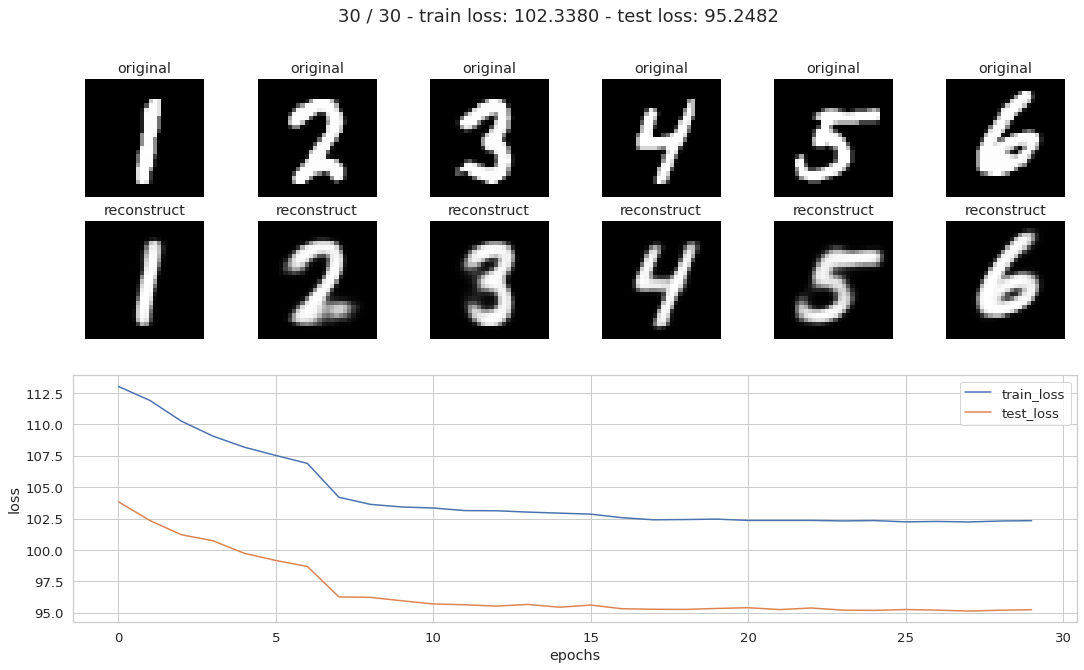

100%|██████████| 30/30 [10:07<00:00, 20.25s/it]

Training is done! Best epoch 28, best time 564.8819034099579, best test loss 95.13776096416886, best train loss 102.23569036292623


In [ ]:
epochs = 30
cvae = train_model(train_loader, test_loader, cvae,
                   'cvae', epochs, criterion, optimizer, scheduler)

<a id='sampling_cvae'></a>
## Sampling

Теперь мы будем сэмплировать из Conditional Variational Autoencoder'а. Это интереснее, чем сэмплировать из простого [AE](https://github.com/ivantipow/Autoencoders/blob/main/1_Vanilla_Autoencoder.ipynb) или [VAE](https://github.com/ivantipow/Autoencoders/blob/main/2_Variational_Autoencoder.ipynb), поскольку тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов.

Давайте, например, для MNIST попросим CVAE восстановить из одинаковых латентных векторов изображения цифр 5 и 7.

In [ ]:
# Загрузим обученный CVAE
cvae = CVAE().to(DEVICE)
cvae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_cvae.pth')))

<All keys matched successfully>

Сгенерируем 10 векторов размерности dim_cvae  из стандартного нормального распределения. После этого из каждого такого латентного вектора восстановим через декодер изображения цифр 5 и 7.

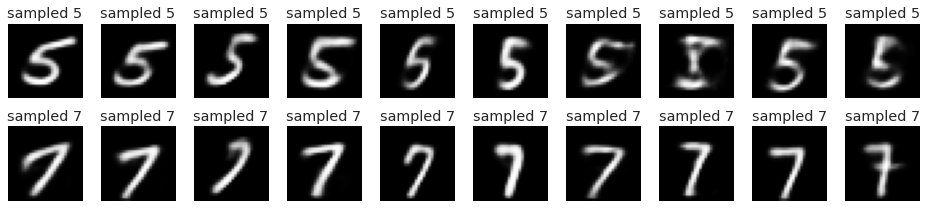

In [ ]:
number_sample = 10

z = torch.randn((number_sample, dim_cvae)).to(DEVICE)

label_5 = torch.full((number_sample,), 5).to(DEVICE)
label_7 = torch.full((number_sample,), 7).to(DEVICE)

with torch.no_grad():
    cvae.eval()
    output_5 = cvae.decode(z, label_5).cpu().squeeze(1).numpy()
    output_7 = cvae.decode(z, label_7).cpu().squeeze(1).numpy()

plt.figure(figsize=(13, 3))
for i in range(number_sample):
    plt.subplot(2, number_sample, i+1)
    plt.axis("off")
    plt.imshow(output_5[i], cmap='gray')
    plt.title('sampled 5')

    plt.subplot(2, number_sample, i+1 + number_sample)
    plt.axis("off")
    plt.imshow(output_7[i], cmap='gray')
    plt.title('sampled 7')

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.show()

На рисунке выше в одном столбце разные цифры, сгенерированные из одного и того же латентного вектора.

Теперь давайте возьмем 100 случайных векторов из стандартного нормального распределения и на основе их сгенерируем по 10 изображений для каждого из 10 классов (для каждой цифры от 0 до 9).

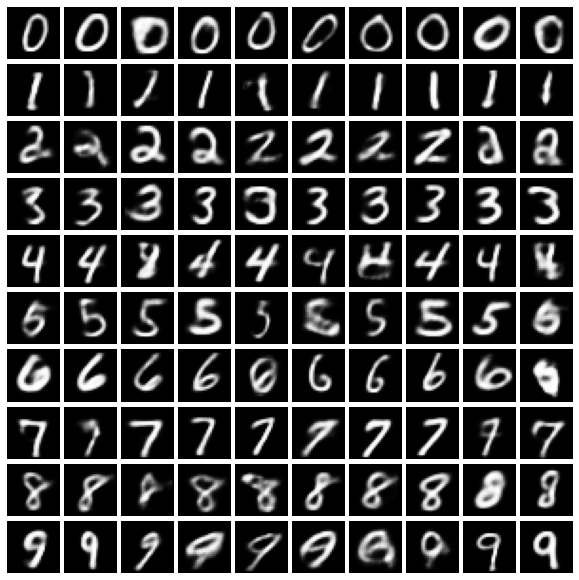

In [ ]:
number_sample = 100

# Генерируем 100 векторов из  стандартного нормального распределения
z = torch.randn((number_sample, dim_cvae)).to(DEVICE)

# Метки от 0 до 9 (каждая записана по 10 раз)
labels = np.array([j for j in range(10) for i in range(10)])
labels = torch.Tensor(labels).int().to(DEVICE)

# Восстанавливаем 100 изображений
with torch.no_grad():
    cvae.eval()
    output = cvae.decode(z, labels).cpu().squeeze(1).numpy()

# Визуализируем результат
plt.figure(figsize=(8, 8))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    plt.imshow(output[i], cmap='gray')

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.show()

<a id='latent_rep'></a>
## Latent Representation

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE сжатое до $ℝ^2$ через tSNE, и сравним её с аналогичной картинкой для VAE, полученной в [предыдущем блокноте](https://github.com/ivantipow/Autoencoders/blob/main/2_Variational_Autoencoder.ipynb).

Опять же, покрасим точки в разные цвета в зависимости от класса.

In [ ]:
# Загрузим обученный CVAE
cvae = CVAE().to(DEVICE)
cvae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_cvae.pth')))

<All keys matched successfully>

In [ ]:
labels = np.zeros(1)
latent_vectors = np.zeros((1, 8))

# Получим латентные представление картинок (цифр) тестового датасета
with torch.no_grad():
    cvae.eval()
    for inputs, label in test_loader:
        inputs = inputs.to(DEVICE)
        lat_vect_batch = cvae.get_latent(inputs, label.to(DEVICE))
        latent_vectors = np.concatenate(
            (latent_vectors, lat_vect_batch.cpu().numpy()))
        labels = np.concatenate((labels, label.numpy()))

labels = np.delete(labels, 0, axis=0)
latent_vectors = np.delete(latent_vectors, 0, axis=0)

# Запишем латентные векторы и их лейблы в файл
dict_latent_cvae = {
    'latent_vectors': latent_vectors,
    'labels': labels}

with open(os.path.join(DATA_DIR, 'dict_latent_cvae.pickle'), 'wb') as f:
    pickle.dump(dict_latent_cvae, f)

print(f'Размеры полученных латентных векторов: {latent_vectors.shape}.')
print(f'Размеры полученных лейблов латентных векторов: {labels.shape}.')

Размеры полученных латентных векторов: (10000, 8).
Размеры полученных лейблов латентных векторов: (10000,).


In [ ]:
# Загрузим латентные векторы и лейблы из словаря
with open(os.path.join(DATA_DIR, 'dict_latent_cvae.pickle'), 'rb') as f:
    dict_latent_cvae = pickle.load(f)

# Сожмем латентные векторы
latent_vectors = dict_latent_cvae['latent_vectors']
tsne_vectors = TSNE(
    n_components=2, random_state=42).fit_transform(latent_vectors)

# Запишем сжатые представления латентых векторов
dict_latent_cvae['tsne_vectors'] = tsne_vectors
with open(os.path.join(DATA_DIR, 'dict_latent_cvae.pickle'), 'wb') as f:
    pickle.dump(dict_latent_cvae, f)

print('Размеры сжатых латентных векторов:', tsne_vectors.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Размеры сжатых латентных векторов: (10000, 2)


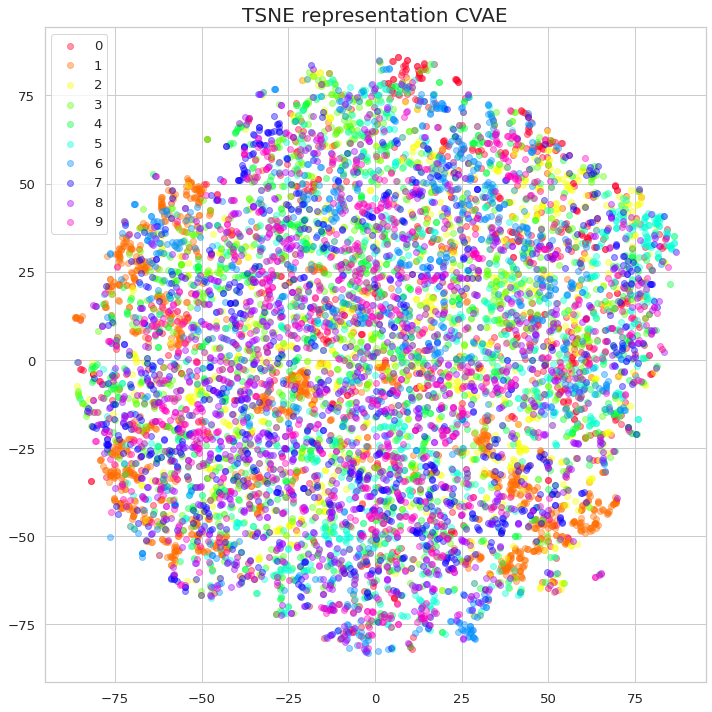

In [ ]:
# Загрузим латентные векторы и лейблы из словаря
with open(os.path.join(DATA_DIR, 'dict_latent_cvae.pickle'), 'rb') as f:
    dict_latent_cvae = pickle.load(f)

latent_vectors = dict_latent_cvae['latent_vectors']
labels = dict_latent_cvae['labels']
tsne_vectors = dict_latent_cvae['tsne_vectors']

# Отрисуем изображение латентных векторов
colors = cm.gist_rainbow(np.linspace(0, 1, len(np.unique(labels))))

plt.figure(figsize=(10, 10))
for label, color in zip(np.unique(labels), colors):
    plt.scatter(tsne_vectors[labels == label, 0],
                tsne_vectors[labels == label, 1],
                c=color.reshape(1, -1),
                alpha=0.4,
                label=str(int(label))
                )

plt.title('TSNE representation CVAE', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

После сжатия через TSNE видим, что  распределение точек в латентном пространстве Convolutional Variational Autoencoder'а заметно отличается от распределения этих же картинок в латентном пространстве простого Variational Autoencoder'а. В латентном пространстве CVAE в отличие от VAE сложно выделить какую-либо кластерную структуру, точки различных классов распределены более равномерно. 

Несмотря на это, CVAE неплохо справляется с задачей генерации новых картинок определенного класса. Понятно, что это связано с наличием подпрастранства бинарных признаков, отвечающих различным классам, которое мы добавляем при работе с CVAE.